<img src="./images/icos.png" />

# A little demonstrator to access the LimeSurvey service.
We host the limesurvey software (http://www.limesurvey.org) to provide a tool for  gathering
information about ICOS.

## load modules

In [35]:
import os
import sys
import base64
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, HTML
sys.path.append(os.getcwd())

# custom libraries
import icoslimer
import report



## set server and authentication


In [36]:
url = 'http://localhost/limesurvey/index.php/admin/remotecontrol'
usr = 'limey'
pwd = 'EnvriPlus'

## create a new limesurvye instance

In [37]:
lime = icoslimer.IcosLimer()
lime.set_url(url)
lime.set_auth(usr, pwd)
lime.set_session_key()

## get all surveys

In [38]:
surveys = lime.list_surveys()

for s in surveys['result']:
    print(s)

{'sid': '312777', 'surveyls_title': 'testi', 'startdate': None, 'expires': '2019-04-03 03:19:21', 'active': 'N'}
{'sid': '341979', 'surveyls_title': 'staticpdf', 'startdate': None, 'expires': None, 'active': 'Y'}
{'sid': '424932', 'surveyls_title': 'just add add survey to add another timeline....', 'startdate': None, 'expires': None, 'active': 'Y'}


## extract the statistics for the surveys and store them in a list

### define the oprtions for the output
@ output_format (string): choose between **html, xls, pdf**. Default is set to '**html**'.<br>
@ lang (string):  yout can choose a specific language, provide empty string for survey default language.<br>
@ graph (string for bool, 0|1): set graph to "1" if you like to have bar charts included. This works only with pdf.

In [39]:
output_format = 'html'
lang = ''
graph = '0'

### check all surveys for stats. If stats are found, store in list, otherwise skip.
<br>(Uncomment the print statement to see error messages.

In [40]:
stats_list = []

for s in surveys['result']:

    stats = lime.get_statistics(s['sid'], output_format)

    # check if it is a json object and decode base64
    try:        
        stats = base64.b64decode(stats['result'])          
        stats_list.append([s['sid'], stats])
    except:
        pass
        #print(stats['error'])
if len(stats_list) > 0:
    print(str(len(stats_list)) + ' stats available')


2 stats available


## You can get a timline for submissions to the survery. 
<br>
@ startdate(string): yyyymmdd<br>
@ enddate(string): yyyymmdd

In [41]:
startdate = '20190101'
enddate = '20251231'


timeline_list = []  
for s in stats_list:
    t = lime.get_timeline(s[0], 'day', startdate, enddate)
    timeline_list.append([s[0], t['result']])
    

### release the session key to the limesurvey server. We have now all the information stored:

In [42]:
lime.release_session_key()

### Store the stats as file
The output is a file for each survey in the format of surveyid.output_format, ***./out/123456.xls***

In [43]:
# make sure the output directories are available
if not os.path.isdir('out'):
    os.mkdir('out')
    
for index, stats in stats_list:
    if not os.path.isdir('./out/'+index):
        os.mkdir('./out/' + index)
    with open('./out/' + index + '/' +index + '.' + output_format, 'wb') as f:
        f.write(stats)

### If output_format is  "html",  display the html file

(as an example we display only the first file)

In [44]:
if output_format == 'html' and len(stats_list) > 0:
    f = './out/' +stats_list[0][0] + '/' + stats_list[0][0] + '.' + output_format
    display(HTML(filename=f))


### If output_format is  "xls",  read the data into a pandas data frame to calculate your own statistics

In [45]:
if output_format == 'xls':
    for id, s in stats_list:
        dataframe = pd.read_excel(io.BytesIO(s))        
        display(dataframe)

 ### We have extracted the timelines for each survey, we can display the table or plot a graph


In [46]:
# display a panda dataframe
col = ['sid', 'count']
df = pd.DataFrame(timeline_list, columns=col)
display(df)

,sid,count
0,341979,"{'2019-04-03': 7, '2019-04-04': 3, '2019-04-05..."
1,424932,{'2019-04-24': 4}


In [47]:
# extract the values from the "dict" and display as pandas table
for t in timeline_list:
    val = []
    sid = t[0]
    data = t[1]
    for k,v in data.items():
        val.append([sid,k,v])
    
    df = pd.DataFrame(val, columns=['sid', 'time', 'count'])
    display(df)

,sid,time,count
0,341979,2019-04-03,7
1,341979,2019-04-04,3
2,341979,2019-04-05,4


,sid,time,count
0,424932,2019-04-24,4


# use matplotlib to create a combined lineplot and markers for all surveys

(0, 7.2)

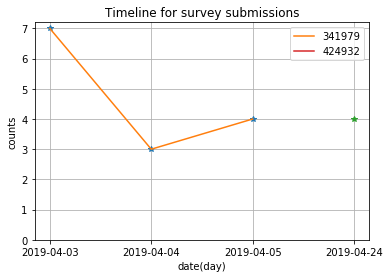

In [48]:


fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date(day)', ylabel='counts',
       title='Timeline for survey submissions')

for t in timeline_list:
    ts=[]
    count=[]
    sid = t[0]
    data = t[1]
    for k,v in data.items():        
        ts.append(v)
        count.append(k)
    ax.plot(count, ts, '*')
    ax.plot(count, ts, label=sid)

ax.legend()
ax.set_ylim(bottom=0)

### use the same plot, but instead safe figures individually for each survey

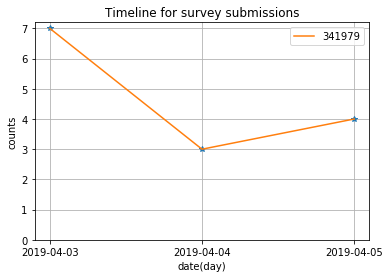

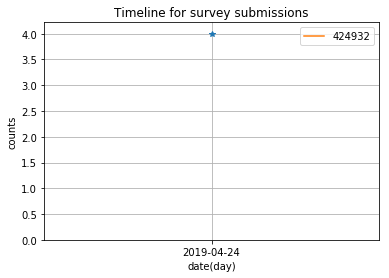

In [49]:
for t in timeline_list:
    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='date(day)', ylabel='counts',
    title='Timeline for survey submissions')

    ts=[]
    count=[]
    sid = t[0]
    data = t[1]
    for k,v in data.items():        
        ts.append(v)
        count.append(k)
    ax.plot(count, ts, '*')
    ax.plot(count, ts, label=sid)
    ax.legend()
    ax.set_ylim(bottom=0)
    plt.savefig('./out/' + sid + '/' + sid + '_timeline.png', dpi=150, format='png')



## now we have everything together to create a custom report
- we assume that the following variables exist from the script above:
    - surveys, stats_list, timeline_list
- and we assume as well that
    - timeline" images have been saved in form of "surveyid_timeline.png"


In [50]:

templatename = 'envriplus.html'

for detail in surveys['result']:
    
    sid = detail['sid']    
    report_name = sid + '_report.html'
    
    statistic = None
    timeline = None
    detail = None

    # get statistis.
    for s in stats_list:
        if s[0] == sid:
            statistic = s[1]
            # it is "bytes", convert to utf8 text
            statistic = statistic.decode()            
    
    # find the corresponding timeline 
    for t in timeline_list:
        if t[0] == sid:
            # we assume, the timeline image is already saved.
            timeline = sid + '_timeline.png'

    for d in surveys['result']:
        if d['sid'] == sid:
            detail = d
            
            
    # if stats or timeline is missing, skip
    if statistic is None or timeline is None or detail is None:
        pass
    else:        
        # create the report and safe to file
        r = report.report(templatename,detail, statistic, timeline)
        
        with open('./out/'+ sid + '/' + report_name, 'w') as f:
            f.write(r)
            